Anime Recommender sysstem using user data from MyAnimeList.net 


In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [2]:
anime_data = pd.read_csv('anime.csv')
anime_data_ = pd.read_csv('rating_complete.csv')
anime_data = anime_data.drop(['Aired','Duration', 'Completed', 'Premiered','English name','Japanese name', 'Episodes', 'Licensors', 'Producers','Watching', 'On-Hold','Dropped','Plan to Watch', 'Rating', 'Studios', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'], axis = 1)


In [3]:
anime_data = anime_data[(anime_data['Score'] != 'Unknown') & (anime_data['Name'] != 'Unknown') & (anime_data['Type'] == 'TV')]
anime_data = anime_data.rename(columns = {'MAL_ID':'anime_id','Genders': 'Genre'})
id_list = list(anime_data["anime_id"])
anime_data['anime_id'] = anime_data['anime_id'].apply(lambda x: x-1)
anime_data

,anime_id,Name,Score,Genre,Type,Source,Ranked,Popularity,Members,Favorites
0,0,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Original,28.0,39,1251960,61971
2,5,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,Manga,266.0,201,558913,12944
3,6,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,Original,2481.0,1467,94683,587
4,7,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,Manga,3710.0,4369,13224,18
5,14,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",TV,Manga,604.0,1003,148259,2066
...,...,...,...,...,...,...,...,...,...,...
17328,44043,Jimihen!!: Jimiko wo Kaechau Jun Isei Kouyuu!!,6.12,"Romance, Ecchi",TV,Manga,7726.0,3876,17613,194
17365,44207,Yami Shibai 8,6.09,"Dementia, Horror, Supernatural",TV,Original,7853.0,6210,5556,14
17373,44234,Pui Pui Molcar,8.33,Kids,TV,Other,206.0,7521,3418,73
17459,45781,D4DJ Petit Mix,6.51,"Music, Comedy",TV,Original,5857.0,9458,1575,8


In [4]:
anime_ratings = anime_data_.loc[anime_data_['anime_id'].isin(id_list)]
anime_ratings['anime_id'] = anime_ratings['anime_id'].apply(lambda x: x-1)
anime_ratings

/home/josh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,anime_id,rating
2,0,3009,7
4,0,2761,9
8,0,1570,10
9,0,120,9
10,0,355,9
...,...,...,...
57633263,353404,550,8
57633265,353404,391,9
57633269,353404,812,9
57633275,353404,224,8


In [5]:
#y_pts = anime_data["Name"]
#x_pts = anime_data["Score"]
#plt.scatter(x_pts)
#plt.show()

In [6]:
def get_anime_ratings(num_users):
    return anime_ratings[(anime_ratings['user_id'] < num_users)]
#1000 users

In [7]:
anime_ratings = get_anime_ratings(1000)

In [8]:
def create_sparse_data(df):
    row = df.to_numpy()[:,0]
    col = df.to_numpy()[:,1]
    d_points = df.to_numpy()[:,2].astype('float64')
    return csr_matrix((d_points,(row, col))).toarray()

In [9]:
sparse_anime = create_sparse_data(anime_ratings)


In [10]:
#print(np.unique(anime_data["Genre"]).shape)

In [11]:
sparse_train_anime, sparse_test_anime = train_test_split(sparse_anime, test_size = 0.20, random_state=42)


In [12]:
def create_init_U_V(embedding_dim):
    U = np.random.normal(0, 0.05*np.sqrt(embedding_dim), (sparse_train_anime.shape[0], embedding_dim))
    V = np.random.normal(0, 0.05*np.sqrt(embedding_dim), (sparse_train_anime.shape[1], embedding_dim))
    return U, V


In [14]:
U, V = create_init_U_V(100)

In [15]:
def sparse_MSE(A, U, V):
    S = np.count_nonzero(A)
    i = list(np.nonzero(A)[0])
    j = list(np.nonzero(A)[1])
    sum_errors = 0
    for i, j in zip(i,j):
        sum_errors += (A[i][j] - U[i].dot(V[j]))**2
    return 1/S*sum_errors

In [16]:
#np.count_nonzero(sparse_train_anime)
#U_V


In [17]:
sparse_MSE(sparse_train_anime, U, V)

67.22998408125726

In [18]:
def sgd_model(num_iterations, lambda_, A, U, V, eps):
    
    samples = [
            (i, j, A[i, j])
            for i in range(A.shape[0])
            for j in range(A.shape[1])
            if A[i, j] > 0
        ]

    errs = []
    epoch = []
    for _ in range(num_iterations):
        
        np.random.shuffle(samples)

        for i, j, a in samples:
            U[i,:] += 2*lambda_*((a - U[i].dot(V[j]))*V[j,:] - eps*V[j,:])
            V[j,:] += 2*lambda_*((a - U[i].dot(V[j]))*U[i,:] - eps*U[i,:])
        epoch.append(_)
        errs.append(sparse_MSE(A, U, V))
    plt.plot(epoch,errs)
    plt.xlabel("Epoch")
    plt.ylabel("Training Error")
    plt.show()
    return U, V
    

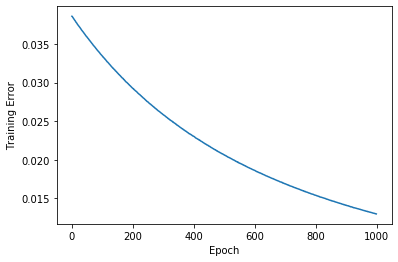

In [21]:
U_sgd, V_sgd = sgd_model(1000, 0.0002, sparse_train_anime, U, V, 0.03)


In [22]:
sparse_MSE(sparse_test_anime, U_sgd, V_sgd)

20.172126268457134

In [23]:
def alternating_least_squares_model(embedding_dim):
    model = NMF(n_components=embedding_dim, init='random', random_state=0)
    U_ = model.fit_transform(sparse_train_anime)
    V_ = model.components_
    return U_, V_


In [24]:
U_, V_ = alternating_least_squares_model(100)
sparse_MSE(sparse_test_anime, U_, V_.T)

50.0505302857167

In [25]:
def dot_similarity(u,V):
    return np.dot(u,V)

In [26]:
def cosine_similarity(u,V):
    return np.dot(u,V)/(np.linalg.norm(u)*np.linalg.norm(V))

In [29]:
def get_recommendation(sim_function, user_id, U, V, num_recommendations):
    u = U[user_id]
    list_recommendations = pd.Series(sim_function(u, V)).sort_values(ascending = False).head(num_recommendations).index.to_numpy()
    user_prefs = anime_ratings.loc[anime_ratings['user_id'] == user_id].sort_values(by=["rating"], ascending = False).head(num_recommendations)['anime_id'].to_numpy()
    return anime_data[anime_data["anime_id"].isin(list_recommendations)], anime_data[anime_data["anime_id"].isin(user_prefs)]
    
    

In [30]:
user_recs, user_prefs = get_recommendation(dot_similarity, 301, U_sgd, V_sgd.T, 10)

In [31]:
user_recs

,anime_id,Name,Score,Genre,Type,Source,Ranked,Popularity,Members,Favorites
40,58,Chobits,7.43,"Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen",TV,Manga,1804.0,332,402646,3859
124,145,Kono Minikuku mo Utsukushii Sekai,6.76,"Sci-Fi, Comedy, Drama, Magic, Romance, Ecchi",TV,Original,4625.0,2145,54222,178
213,236,Koukyoushihen Eureka Seven,8.09,"Adventure, Drama, Mecha, Romance, Sci-Fi",TV,Original,426.0,351,379048,9241
4892,7078,Ookamikakushi,6.34,"Action, Mystery, Horror, Supernatural",TV,Visual novel,6702.0,1869,66271,91
6059,10079,Kami nomi zo Shiru Sekai II,7.94,"Comedy, Harem, Romance, Shounen, Supernatural",TV,Manga,618.0,423,325315,1026
6520,11318,Zero no Tsukaima F,7.52,"Adventure, Magic, Romance, Ecchi, Fantasy",TV,Light novel,1508.0,412,333447,1201
8117,19646,Hajime no Ippo: Rising,8.6,"Comedy, Sports, Drama, Shounen",TV,Manga,69.0,851,175315,1010
8217,20056,Space☆Dandy,7.88,"Sci-Fi, Space, Comedy",TV,Original,701.0,537,267394,4324
11109,31763,Nejimaki Seirei Senki: Tenkyou no Alderamin,7.73,"Action, Adventure, Fantasy, Military",TV,Light novel,949.0,589,245963,1225
13351,35993,Satsuriku no Tenshi,6.87,"Adventure, Horror, Psychological, Thriller",TV,Game,4149.0,351,382383,4552


In [32]:
user_prefs

,anime_id,Name,Score,Genre,Type,Source,Ranked,Popularity,Members,Favorites
0,0,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Original,28.0,39,1251960,61971
20,29,Neon Genesis Evangelion,8.32,"Action, Sci-Fi, Dementia, Psychological, Drama...",TV,Original,208.0,54,1160651,71308
315,338,Serial Experiments Lain,8.03,"Dementia, Drama, Mystery, Psychological, Sci-F...",TV,Original,509.0,255,480696,16764
1393,1534,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",TV,Manga,60.0,1,2589552,145201
1822,2000,Tengen Toppa Gurren Lagann,8.66,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,Original,52.0,46,1213765,67916
2656,2903,Code Geass: Hangyaku no Lelouch R2,8.91,"Action, Military, Sci-Fi, Super Power, Drama, ...",TV,Original,18.0,36,1268320,64482
5683,9252,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,Visual novel,3.0,9,1771162,148452
7140,14512,Magi: The Labyrinth of Magic,8.07,"Action, Adventure, Fantasy, Magic, Shounen",TV,Manga,456.0,110,775824,8319
7821,18114,Magi: The Kingdom of Magic,8.28,"Action, Adventure, Magic, Fantasy, Shounen",TV,Manga,244.0,160,639860,7471
14963,38523,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",TV,Manga,4.0,63,1073626,40985


In [33]:
user_recs_als, user_prefs_als = get_recommendation(cosine_similarity, 301, U_, V_, 10)

In [34]:
user_recs_als

,anime_id,Name,Score,Genre,Type,Source,Ranked,Popularity,Members,Favorites
1393,1534,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",TV,Manga,60.0,1,2589552,145201
6061,10086,Fate/Zero,8.34,"Action, Supernatural, Magic, Fantasy",TV,Light novel,192.0,59,1090273,30267
6607,11740,Fate/Zero 2nd Season,8.59,"Action, Supernatural, Magic, Fantasy",TV,Light novel,71.0,105,808294,17197
6614,11756,Sword Art Online,7.25,"Action, Game, Adventure, Romance, Fantasy",TV,Light novel,2584.0,4,2214395,66342
7449,16497,Shingeki no Kyojin,8.48,"Action, Military, Mystery, Super Power, Drama,...",TV,Manga,115.0,2,2531397,129844
8625,22198,Akame ga Kill!,7.53,"Action, Adventure, Drama, Fantasy, Shounen",TV,Manga,1483.0,25,1408729,23395
8644,22296,Fate/stay night: Unlimited Blade Works,8.22,"Action, Fantasy, Magic, Supernatural",TV,Visual novel,292.0,119,742718,12756
8646,22318,Tokyo Ghoul,7.81,"Action, Mystery, Horror, Psychological, Supern...",TV,Manga,807.0,7,1895488,45519
9664,27898,Tokyo Ghoul √A,7.07,"Action, Mystery, Horror, Psychological, Supern...",TV,Manga,3343.0,42,1226168,11097
9853,28700,Fate/stay night: Unlimited Blade Works 2nd Season,8.33,"Action, Fantasy, Magic, Supernatural",TV,Visual novel,201.0,175,605173,7133


In [35]:
user_prefs_als

,anime_id,Name,Score,Genre,Type,Source,Ranked,Popularity,Members,Favorites
0,0,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Original,28.0,39,1251960,61971
20,29,Neon Genesis Evangelion,8.32,"Action, Sci-Fi, Dementia, Psychological, Drama...",TV,Original,208.0,54,1160651,71308
315,338,Serial Experiments Lain,8.03,"Dementia, Drama, Mystery, Psychological, Sci-F...",TV,Original,509.0,255,480696,16764
1393,1534,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",TV,Manga,60.0,1,2589552,145201
1822,2000,Tengen Toppa Gurren Lagann,8.66,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,Original,52.0,46,1213765,67916
2656,2903,Code Geass: Hangyaku no Lelouch R2,8.91,"Action, Military, Sci-Fi, Super Power, Drama, ...",TV,Original,18.0,36,1268320,64482
5683,9252,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,Visual novel,3.0,9,1771162,148452
7140,14512,Magi: The Labyrinth of Magic,8.07,"Action, Adventure, Fantasy, Magic, Shounen",TV,Manga,456.0,110,775824,8319
7821,18114,Magi: The Kingdom of Magic,8.28,"Action, Adventure, Magic, Fantasy, Shounen",TV,Manga,244.0,160,639860,7471
14963,38523,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",TV,Manga,4.0,63,1073626,40985
